In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory, label)): #  os.path.join to join directory with label
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels


In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./train\sad\Training_13488691.jpg,sad
1,./train\sad\Training_60332462.jpg,sad
2,./train\neutral\Training_11425879.jpg,neutral
3,./train\surprise\Training_43624263.jpg,surprise
4,./train\sad\Training_65267116.jpg,sad


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,./test\happy\PrivateTest_10077120.jpg,happy
1,./test\happy\PrivateTest_10470092.jpg,happy
2,./test\happy\PrivateTest_10513598.jpg,happy
3,./test\happy\PrivateTest_10516065.jpg,happy
4,./test\happy\PrivateTest_10613684.jpg,happy


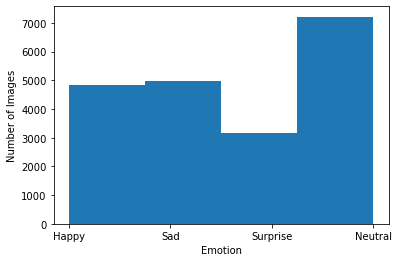

In [6]:
fig, ax = plt.subplots()
ax.hist(train['label'], bins=4)
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of Images')
ax.set_xticks(range(4))
ax.set_xticklabels(['Happy', 'Sad', 'Surprise', 'Neutral'])
plt.show()
# This will create a histogram with the count of images for each emotion label using Matplotlib. The set_xticks and set_xticklabels methods are used to for the x-axis ticks, since the emotion labels are represented by numbers in the data set.


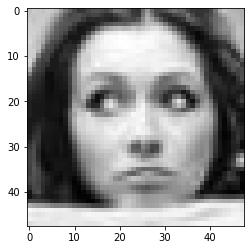

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

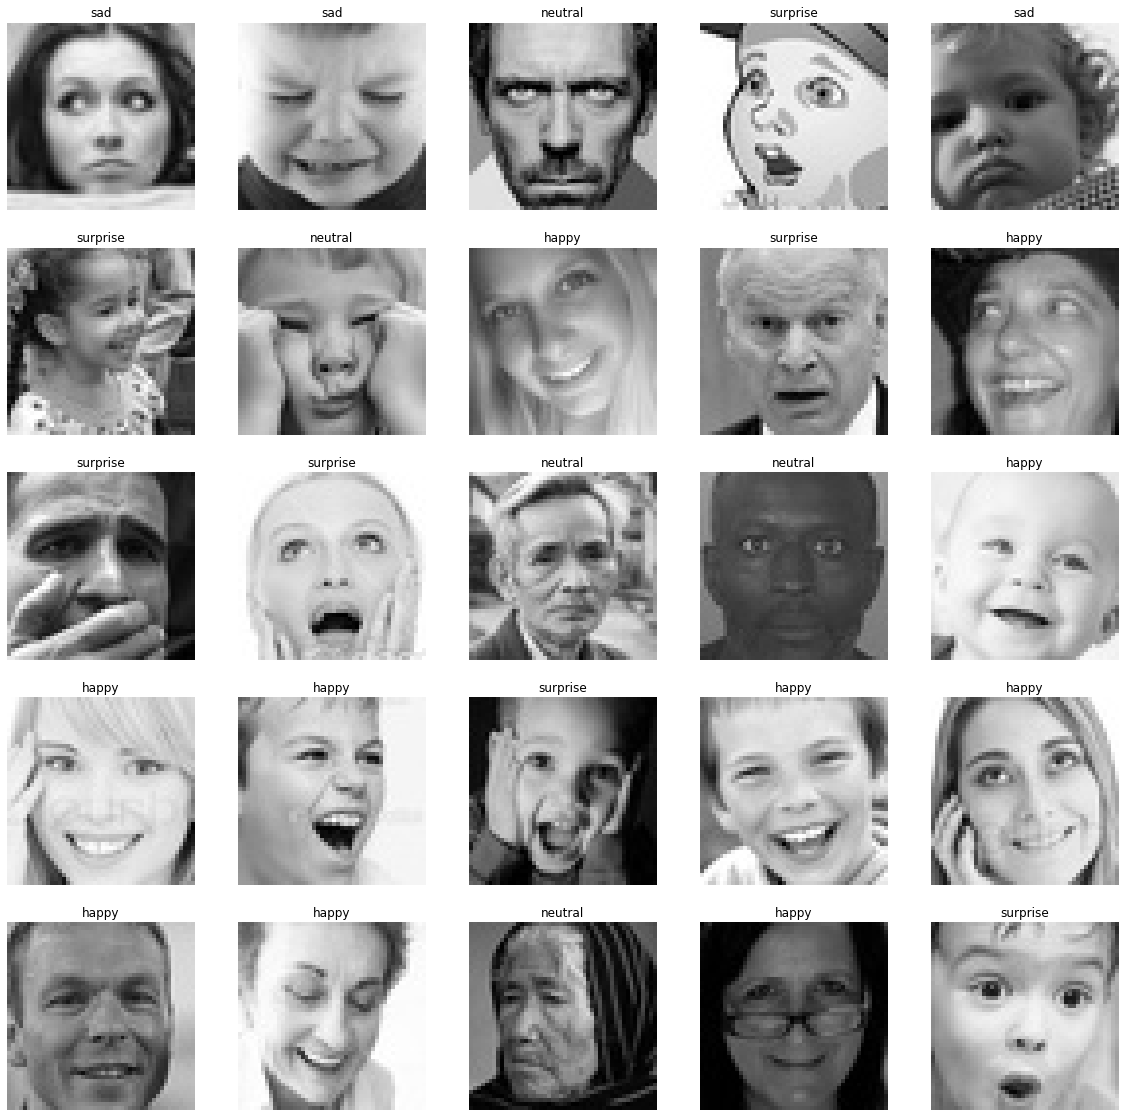

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/20181 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/5084 [00:00<?, ?it/s]

In [12]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [15]:
# config
input_shape = (48, 48, 1)
output_class = 4

This code uses a smaller network architecture with fewer layers and less complex filters to prevent overfitting. We also increased the number of epochs to 30 for better training. Additionally, we added an early stopping mechanism to avoid overfitting.

In [16]:

model = Sequential()

# convolutional layers
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=13, validation_data=(x_test, y_test), verbose=1)

Epoch 1/13
158/158 [==============================] - 117s 726ms/step - loss: 1.2438 - accuracy: 0.4273 - val_loss: 1.0400 - val_accuracy: 0.5596
Epoch 2/13
158/158 [==============================] - 114s 719ms/step - loss: 0.9865 - accuracy: 0.5809 - val_loss: 0.8638 - val_accuracy: 0.6320
Epoch 3/13
158/158 [==============================] - 112s 708ms/step - loss: 0.8567 - accuracy: 0.6417 - val_loss: 0.8071 - val_accuracy: 0.6572
Epoch 4/13
158/158 [==============================] - 118s 748ms/step - loss: 0.7908 - accuracy: 0.6750 - val_loss: 0.7502 - val_accuracy: 0.6896
Epoch 5/13
158/158 [==============================] - 114s 720ms/step - loss: 0.7339 - accuracy: 0.7011 - val_loss: 0.7185 - val_accuracy: 0.7054
Epoch 6/13
158/158 [==============================] - 113s 714ms/step - loss: 0.6805 - accuracy: 0.7242 - val_loss: 0.7111 - val_accuracy: 0.7057
Epoch 7/13
158/158 [==============================] - 112s 711ms/step - loss: 0.6377 - accuracy: 0.7440 - val_loss: 0.6759 -

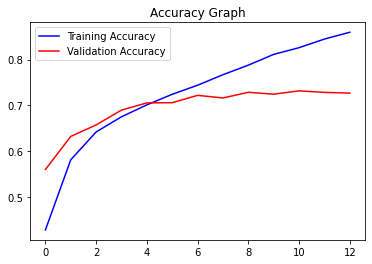

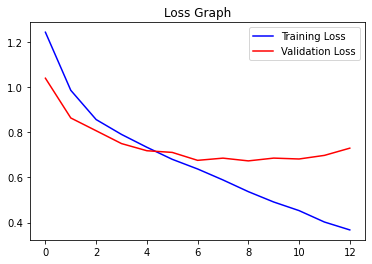

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Label:  sad
1/1 [==============================] - 0s 26ms/step
Prediction:  sad


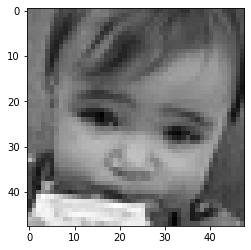

In [28]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  sad
1/1 [==============================] - 0s 33ms/step
Prediction:  surprise


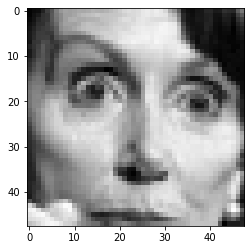

In [20]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  happy
1/1 [==============================] - 0s 30ms/step
Prediction:  happy


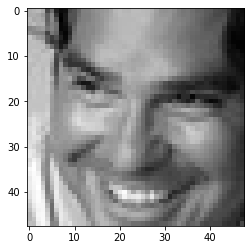

In [21]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  neutral
1/1 [==============================] - 0s 31ms/step
Prediction:  neutral


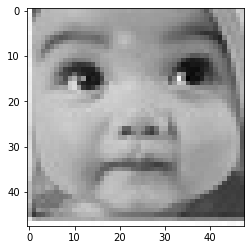

In [29]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  neutral
1/1 [==============================] - 0s 28ms/step
Prediction:  neutral


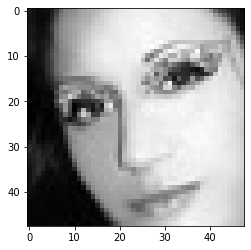

In [23]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  happy
1/1 [==============================] - 0s 29ms/step
Prediction:  happy


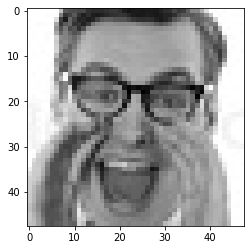

In [24]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Label:  happy
1/1 [==============================] - 0s 27ms/step
Prediction:  happy


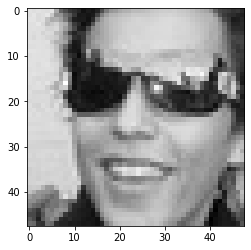

In [30]:
image_index = random.randint(0, len(test))
print("Label: ", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction: ", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

1/1 [==============================] - 0s 24ms/step


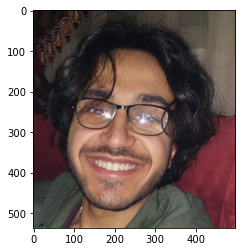

Prediction:  happy
Actual label: happy


In [32]:
from PIL import Image
import numpy as np

# Load the image file
image = Image.open("omar.jpg")

# Convert the image to grayscale
image = image.convert('L')

# Convert the image to a NumPy array
image_array = np.array(image)

# Normalize the pixel values to be between 0 and 1
image_array = image_array / 255.0

# Reshape the array to have a single channel (i.e., depth of 1)
image_array = np.reshape(image_array, (1, 48, 48, 1))

# Make a prediction using your trained model
prediction = model.predict(image_array)

# Convert the prediction from a one-hot encoded vector to a label
prediction_label = le.inverse_transform([np.argmax(prediction)])[0]

image2 = Image.open("omar_original.jpg")
# Display the image inline using Matplotlib
plt.imshow(image2)
plt.show()

# Print the predicted label
print("Prediction: ", prediction_label)
print("Actual label: happy")
